In [ ]:
# Imports
from google.colab import drive
import urllib.request
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel

In [ ]:
# This snippet managed the connection with Google Drive and the generic global variables and functions
# Mount the Google Drive
drive.mount('/content/drive', force_remount=True)
dataset_path = '/content/datasets/'
drive_path = '/content/drive/MyDrive/progetti/machine_deep_learning/sentiment_analysis/'
def download_dataset():
    urllib.request.urlretrieve("https://www.kaggle.com/api/v1/datasets/download/suchintikasarkar/sentiment-analysis-for-mental-health","tweets_mental_health.zip")
    with zipfile.ZipFile("tweets_mental_health.zip", 'r') as zip_ref:
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)
        zip_ref.extractall(dataset_path)
    print("Dataset scaricato con successo")
# Choose the pre trained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# If the CSV was already downloaded we just load it, otherwise we download and load it
if not os.path.exists(dataset_path + 'Combined Data.csv'):
    download_dataset()
else:
    print("Dataset già scaricato")

Dataset scaricato con successo


In [ ]:
# Code to build our datasets
dataset = pd.read_csv(dataset_path + 'Combined Data.csv')
# Select only "statement" and "status" columns
dataset = dataset[['statement', 'status']]
# Remove empty rows
dataset = dataset.dropna()
# Due to BERT limitations we remove all the rows that contains statements longer than 500 characters
dataset = dataset[dataset['statement'].str.len() <= 500]

# Get all the types of status
statuses = dataset['status'].unique()
# Create a dictionary mapping all possible status to int from 0 to max len
status_dictionary = {}
counter = 0
for status in statuses:
    status_dictionary[status] = counter
    counter += 1
print(status_dictionary)
# Convert the statuses
for status in status_dictionary:
    index = status_dictionary[status]
    dataset.loc[dataset['status'] == status, 'status'] = index

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, temp_dataset = train_test_split(dataset, test_size=(val_size + test_size) / len(dataset), random_state=42)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=test_size / (val_size + test_size), random_state=42)

print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

X_train = train_dataset['statement'].tolist()
y_train = train_dataset['status'].tolist()

X_val = val_dataset['statement'].tolist()
y_val = val_dataset['status'].tolist()

X_test = test_dataset['statement'].tolist()
y_test = test_dataset['status'].tolist()

train_dataset.head()
#print(X_train[:5])
#print(y_train[:5])

{'Anxiety': 0, 'Normal': 1, 'Depression': 2, 'Suicidal': 3, 'Stress': 4, 'Bipolar': 5, 'Personality disorder': 6}
Train size: 23307
Validation size: 4994
Test size: 4995


,statement,status
31090,because you helped make it dirty.,1
2661,Mootsss my height increased by 1cmðŸ˜Ž,1
33573,like what?,1
19900,I hate it sm. I just want to end it. Nobody wo...,3
22981,Can anybody talk with me? I do not want to die,3


In [ ]:
# Define the Model

# Since BERT wants a Tensorflow.Tensor as inputs we have to cast the inputs
# Doing so directly in the model declaration doesn't work so we have to create a custom keras layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Cast to tf.int32 inside the call method
        bert_output = self.bert_model(input_ids=tf.cast(input_ids, tf.int32), attention_mask=tf.cast(attention_mask, tf.int32))
        return bert_output.pooler_output

# Define the model

class SentimentAnalysisModel():
    def __init__(self, tokenizer, bert_model):
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.model = None
        self.history = None
        self.status_dictionary = None
    def build_model(self):
        # Layer to get the input tokens after tokenizing the text
        tokens_input = tf.keras.layers.Input(shape = (None,), dtype=tf.int32, name = 'Tokens_Input')
        # Layer to mask the padding
        mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='Mask')
        # Use the custom BertLayer
        bert = BertLayer(self.bert_model)([tokens_input, mask])
        # Dense layer for the predicted rating
        prediction = tf.keras.layers.Dense(7, activation = 'softmax', name = 'Classifier')(bert)
        self.model = tf.keras.Model([tokens_input, mask],prediction)
        # Compile the model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        # Print the model Summary
        self.model.summary()
    def train_model(self, X_train, y_train, X_val, y_val, status_dictionary, epochs=3, batch_size=32, early_stopping_patience=3):
        self.status_dictionary = status_dictionary
        # Tokenize the texts
        tokenized_X_train = self.tokenizer(
            X_train,
            return_tensors="tf",
            padding=True,
            truncation=True,
            max_length=512
        )
        tokenized_X_val = self.tokenizer(
            X_val,
            return_tensors="tf",
            padding=True,
            truncation=True,
            max_length=512
        )

        y_train = tf.keras.utils.to_categorical([rating for rating in y_train], num_classes=7)
        y_val = tf.keras.utils.to_categorical([rating for rating in y_val], num_classes=7)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True
        )

        with tf.device('/device:GPU:0'):
            self.history = self.model.fit(
                {"Tokens_Input": tokenized_X_train["input_ids"], "Mask": tokenized_X_train["attention_mask"]},
                y_train,
                validation_data=({"Tokens_Input": tokenized_X_val["input_ids"], "Mask": tokenized_X_val["attention_mask"]}, y_val),
                batch_size= batch_size,
                epochs=epochs,
                callbacks=[early_stopping]
            )
        # save the model
        self.model.save(drive_path + 'sentiment_analysis_model_mental_health')
        # save the history
        with open(drive_path + 'history_mental_health.pkl', 'wb') as f:
            pickle.dump(self.history.history, f)
        # save the dictionary
        with open(drive_path + 'status_dictionary_mental_health.pkl', 'wb') as f:
            pickle.dump(self.status_dictionary, f)
    def predict(self, review):
        tokenized_review = self.tokenizer(
            [review],
            return_tensors="tf",
            padding=True,
            truncation=True,
            max_length=512
        )
        with tf.device('/device:GPU:0'):
            prediction = self.model.predict(
                {"Tokens_Input": tokenized_review["input_ids"], "Mask": tokenized_review["attention_mask"]},
                verbose = 0
            )
        max_prediction = np.argmax(prediction)
        # Get the condition from the prediction
        prediction = [condition for condition, index in self.status_dictionary.items() if index == max_prediction][0]
        return prediction

In [ ]:
sentiment_analysis_model = SentimentAnalysisModel(tokenizer, bert_model)
sentiment_analysis_model.build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Tokens_Input (InputLayer)   [(None, None)]               0         []                            
                                                                                                  
 Mask (InputLayer)           [(None, None)]               0         []                            
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  1094822   ['Tokens_Input[0][0]',        
                                                          40         'Mask[0][0]']                
                                                                                                  
 Classifier (Dense)          (None, 7)                    5383      ['bert_layer[0][0]']      

In [ ]:
# Try to load the model, history and dictionary from the drive
try:
    # If we find it recreate the class
    model = tf.keras.models.load_model(drive_path + 'sentiment_analysis_model_mental_health')
    sentiment_analysis_model = SentimentAnalysisModel(tokenizer, bert_model)
    sentiment_analysis_model.model = model
    history = pickle.load(open(drive_path + 'history_mental_health.pkl', 'rb'))
    sentiment_analysis_model.history = history
    status_dictionary = pickle.load(open(drive_path + 'status_dictionary_mental_health.pkl', 'rb'))
    sentiment_analysis_model.status_dictionary = status_dictionary
    print("Model loaded from drive")
except:
    # Else we must train the model
    sentiment_analysis_model = SentimentAnalysisModel(tokenizer, bert_model)
    sentiment_analysis_model.build_model()
    epochs = 5
    batch_size = 12
    early_stopping_patience = 2
    sentiment_analysis_model.train_model(X_train, y_train, X_val, y_val, status_dictionary, epochs, batch_size, early_stopping_patience)
    print("Model trained")

Model loaded from drive


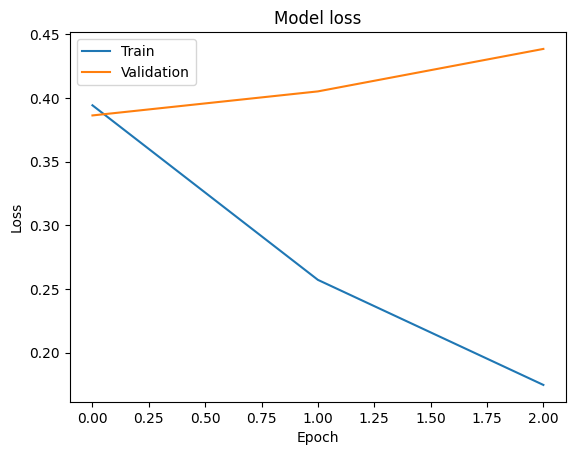

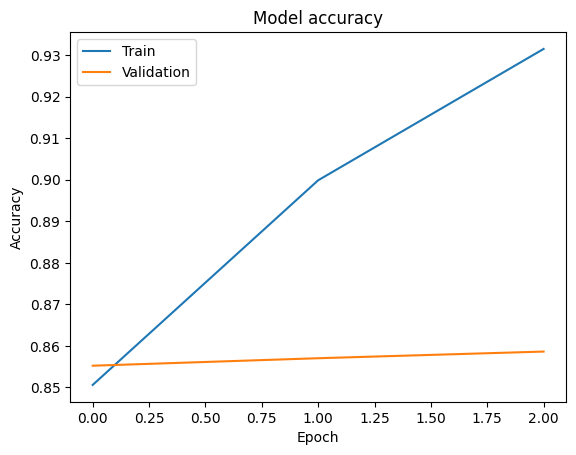

In [ ]:
# Plot the loss and accuracy history
history = sentiment_analysis_model.history

loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Execute the test prediction a number of times by pulling some random example from the test set and create a matrix of real and predicted ratings
number_of_tests = 10
real_statuses = []
predicted_statuses = []
statements = []
for i in range(number_of_tests):
    random_index = np.random.randint(0, len(X_test))
    statement = X_test[random_index]
    real_status = y_test[random_index]
    # Convert the real status using the dictionary inside the class
    real_status = [condition for condition, index in sentiment_analysis_model.status_dictionary.items() if index == real_status][0]
    predicted_status = sentiment_analysis_model.predict(statement)
    real_statuses.append(real_status)
    predicted_statuses.append(predicted_status)
    statements.append(statement)
    # print(f"Statement: {statement}")
    # print(f"Real status : {real_status}")
    # print(f"Predicted status: {predicted_status}")
# Create the pandas dataframe
results = pd.DataFrame({'Real rating': real_statuses, 'Predicted rating': predicted_statuses, 'Statements': statements})
results.head(number_of_tests)

,Real rating,Predicted rating,Statements
0,Depression,Depression,"I am 20 i have bipolar anxiety and depression,..."
1,Normal,Normal,qiqil nyo dreamzens tangina nyo
2,Suicidal,Suicidal,"I was there man, about to jump from the second..."
3,Suicidal,Suicidal,I tried to suffocate myself the other day and ...
4,Depression,Depression,I just moved to a new city and my friends do n...
5,Depression,Suicidal,I really hate what we all deal with. Everyone ...
6,Anxiety,Depression,Are SSRI side effects dose dependent? For exam...
7,Depression,Depression,i try and try but i just can t do it
8,Personality disorder,Personality disorder,Anyone else fantasize about being a part of a ...
9,Depression,Depression,I just feel useless. I feel like my life is no...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Try to predict custom messages
normal_custom_message = "Today went well, going to Costco to get some rotisserie chicken"
depression_custom_message = "I really feel like doing nothing today, everything is gray and food tastes like nothing"
suicidal_custom_message = "Today will be a great day since i will end it all"
luca_custom_message = "I'm worried about the exam i will have in two hours"
messages = [normal_custom_message, depression_custom_message, suicidal_custom_message, luca_custom_message]
predicted_statuses = []
for message in messages:
    predicted_status = sentiment_analysis_model.predict(message)
    predicted_statuses.append(predicted_status)
# Create the pandas dataframe
results = pd.DataFrame({'Message': messages, 'Predicted Status': predicted_statuses})
results.head()

,Message,Predicted Status
0,"Today went well, going to Costco to get some r...",Normal
1,"I really feel like doing nothing today, everyt...",Depression
2,Today will be a great day since i will end it all,Suicidal
3,I'm worried about the exam i will have in two ...,Anxiety
